In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

In [55]:
data = pd.read_csv('unsupervised(elian).csv')
df = pd.DataFrame(data)


In [56]:
df.drop(columns='cluster',inplace=True)

In [57]:
df.duplicated().sum()

5

In [58]:
df.head()

,price,availability_365,room_type,review_scores_rating,neighbourhood_group_cleansed
0,48.0,365,Private room,4.60,East Region
1,60.0,244,Private room,4.69,North-East Region
2,50.0,365,Private room,4.70,East Region
3,200.0,362,Entire home/apt,4.93,East Region
4,60.0,239,Private room,4.81,North-East Region


In [59]:
le_room = LabelEncoder()
le_region = LabelEncoder()


In [60]:
df['room_type_encoded'] = le_room.fit_transform(df['room_type'])
df['neighbourhood_group_cleansed_encoded'] =le_region.fit_transform(df['neighbourhood_group_cleansed'])

In [61]:
room_mapping = dict(zip(le_room.classes_,le_room.transform(le_room.classes_)))
region_mapping = dict(zip(le_region.classes_,le_region.transform(le_region.classes_)))

print("room type mapping: ", room_mapping)
print("region type mapping: ", region_mapping)

room type mapping:  {'Entire home/apt': 0, 'Private room': 1}
region type mapping:  {'East Region': 0, 'North Region': 1, 'North-East Region': 2, 'West Region': 3}


In [62]:
df["estimated_revenue"] = df["price"]*df["availability_365"]

df.head()

,price,availability_365,room_type,review_scores_rating,neighbourhood_group_cleansed,room_type_encoded,neighbourhood_group_cleansed_encoded,estimated_revenue
0,48.0,365,Private room,4.60,East Region,1,0,17520.0
1,60.0,244,Private room,4.69,North-East Region,1,2,14640.0
2,50.0,365,Private room,4.70,East Region,1,0,18250.0
3,200.0,362,Entire home/apt,4.93,East Region,0,0,72400.0
4,60.0,239,Private room,4.81,North-East Region,1,2,14340.0


In [63]:
df["revenue_category"] = pd.qcut(df["estimated_revenue"], q=3, labels=["low","mid","high"])
print(df[df['availability_365'] != 365]['revenue_category'].value_counts())


low     58
high    50
mid     43
Name: revenue_category, dtype: int64


In [64]:
df.head()

,price,availability_365,room_type,review_scores_rating,neighbourhood_group_cleansed,room_type_encoded,neighbourhood_group_cleansed_encoded,estimated_revenue,revenue_category
0,48.0,365,Private room,4.60,East Region,1,0,17520.0,low
1,60.0,244,Private room,4.69,North-East Region,1,2,14640.0,low
2,50.0,365,Private room,4.70,East Region,1,0,18250.0,low
3,200.0,362,Entire home/apt,4.93,East Region,0,0,72400.0,high
4,60.0,239,Private room,4.81,North-East Region,1,2,14340.0,low


In [65]:
x = df[['price','availability_365','review_scores_rating','room_type_encoded','neighbourhood_group_cleansed_encoded']]
y = df["revenue_category"]

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [69]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [70]:
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9211
Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        13
         low       0.92      0.85      0.88        13
         mid       0.85      0.92      0.88        12

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



In [71]:
cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy (5-fold): 0.9316 ± 0.0268


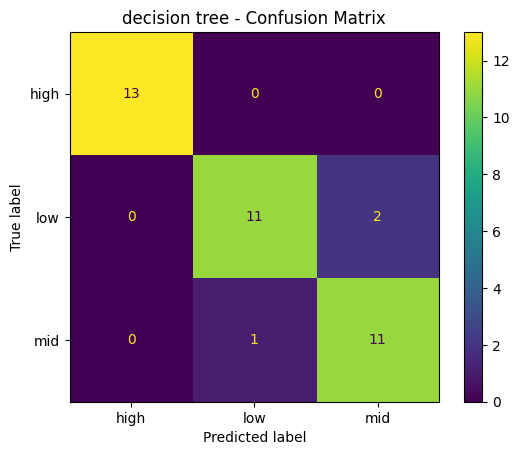

In [72]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("decision tree - Confusion Matrix")
plt.show()

tuning hela

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
dt = DecisionTreeClassifier(random_state=42)

In [75]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

In [76]:
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [93]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best Score: 0.9346236559139784


In [ ]:
best_dt = grid_search.best_estimator_ 
y_pred_tuning = best_dt.predict(X_test)

In [90]:
acc = accuracy_score(y_test, y_pred_tuning)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tuning))

cv_scores = cross_val_score(dt, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Test Accuracy: 0.9211
Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        13
         low       0.92      0.85      0.88        13
         mid       0.85      0.92      0.88        12

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38

Cross-Validation Accuracy (5-fold): 0.9368 ± 0.0211


In [82]:
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Test Accuracy: 0.9211
Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        13
         low       0.92      0.85      0.88        13
         mid       0.85      0.92      0.88        12

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38

Cross-Validation Accuracy (5-fold): 0.9263 ± 0.0197


In [95]:
print("Original model params:")
print(dt.get_params())

print("\nBest model params from GridSearch:")
print(grid_search.best_params_)


Original model params:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}

Best model params from GridSearch:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


cek dt ama best_dt

In [96]:
acc = accuracy_score(y_test, y_pred_tuning)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tuning))

cv_scores = cross_val_score(dt, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Test Accuracy: 0.9211
Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        13
         low       0.92      0.85      0.88        13
         mid       0.85      0.92      0.88        12

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38

Cross-Validation Accuracy (5-fold): 0.9368 ± 0.0211


In [97]:
acc = accuracy_score(y_test, y_pred_tuning)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tuning))

cv_scores = cross_val_score(best_dt, x, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Test Accuracy: 0.9211
Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        13
         low       0.92      0.85      0.88        13
         mid       0.85      0.92      0.88        12

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38

Cross-Validation Accuracy (5-fold): 0.9263 ± 0.0197


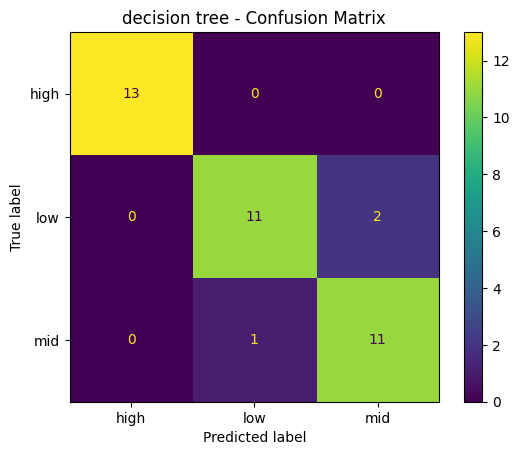

In [98]:
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test)
plt.title("decision tree - Confusion Matrix")
plt.show()